In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Load datasets
train_df = pd.read_csv('./data/house-train.csv')
test_df = pd.read_csv('./data/house-test.csv')

# Combine train and test data for consistent preprocessing
combined_df = pd.concat([train_df, test_df])

# Selecting features
features = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 
            'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
            'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley',
            'LotShape', 'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 
            'SaleCondition']
target = 'SalePrice'

# Handle missing values
# For simplicity, fill numerical missing values with the median, and categorical with the mode
for feature in features:
    if combined_df[feature].dtype == 'object':  # Categorical
        combined_df[feature] = combined_df[feature].fillna(combined_df[feature].mode()[0])
    else:  # Numerical
        combined_df[feature] = combined_df[feature].fillna(combined_df[feature].median())

# Convert categorical features to numerical values
for feature in features:
    if combined_df[feature].dtype == 'object':
        combined_df[feature] = combined_df[feature].astype('category').cat.codes

# Normalize the numerical features
scaler = StandardScaler()
combined_df[features] = scaler.fit_transform(combined_df[features])

# Splitting back into train and test
train_df = combined_df.iloc[:len(train_df), :]
test_df = combined_df.iloc[len(train_df):, :]

# Splitting into features and target
X_train, X_test = train_df[features], test_df[features]
y_train, y_test = train_df[target], test_df[target]

# Splitting the training set for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer
        )
    
    def forward(self, x):
        return self.layers(x)

# Model instantiation
input_size = len(features)
model = MLP(input_size=input_size)


In [15]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #learning rate has been adjusted to 0.01

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation loss
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}')


Epoch [10/100], Loss: 1344879616.0, Validation Loss: 1327491328.0
Epoch [20/100], Loss: 1336738176.0, Validation Loss: 1321768576.0
Epoch [30/100], Loss: 1328837888.0, Validation Loss: 1316813952.0
Epoch [40/100], Loss: 1321137920.0, Validation Loss: 1311330432.0
Epoch [50/100], Loss: 1313629824.0, Validation Loss: 1305925376.0
Epoch [60/100], Loss: 1306316416.0, Validation Loss: 1300698880.0
Epoch [70/100], Loss: 1299182976.0, Validation Loss: 1295547648.0
Epoch [80/100], Loss: 1292206592.0, Validation Loss: 1290437120.0
Epoch [90/100], Loss: 1285387392.0, Validation Loss: 1285537280.0
Epoch [100/100], Loss: 1278735232.0, Validation Loss: 1280594944.0


Epoch [10/100], Loss: 1272246784.0, Validation Loss: 1275768192.0
Epoch [20/100], Loss: 1265891840.0, Validation Loss: 1271246464.0
Epoch [30/100], Loss: 1259683328.0, Validation Loss: 1266581888.0
Epoch [40/100], Loss: 1253613440.0, Validation Loss: 1262081792.0
Epoch [50/100], Loss: 1247675264.0, Validation Loss: 1258055296.0
Epoch [60/100], Loss: 1241868928.0, Validation Loss: 1253768576.0
Epoch [70/100], Loss: 1236173440.0, Validation Loss: 1249838208.0
Epoch [80/100], Loss: 1230592896.0, Validation Loss: 1245773312.0
Epoch [90/100], Loss: 1225193856.0, Validation Loss: 1241994240.0
Epoch [100/100], Loss: 1219902336.0, Validation Loss: 1238421248.0


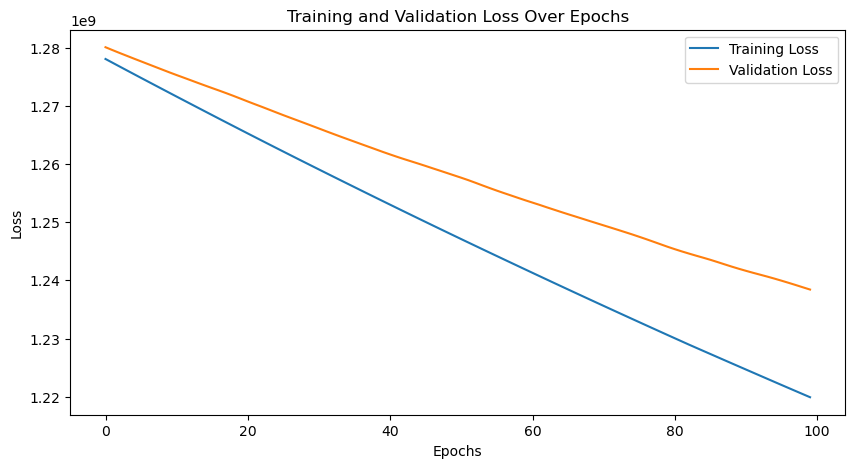

RMSE on Validation Set: 35191.2109375


In [16]:
import matplotlib.pyplot as plt

# Adjusted Training loop to store losses
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation loss
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate RMSE on validation set
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    mse = criterion(val_predictions, y_val_tensor)
    rmse = torch.sqrt(mse).item()
    print(f'RMSE on Validation Set: {rmse}')
